In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


vgg pretrained - fine tuned (multi - channel)

In [ ]:
import tensorflow as tf
from keras.layers import Conv3D, Dense, MaxPooling3D, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, MaxPooling2D, Conv2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.vgg16 import VGG16

from keras.applications.vgg16 import preprocess_input

import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt

import csv

In [ ]:
# adam optimizer default learning rate = 0.001
lr = 0.0001 #learning rate
ep = 1
batch_size = 1
n_splits = 5

In [ ]:
# not performing fine tuning during training
def get_model(input_shape, num_classes):

    #returns compiled model for the smri pipeline
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape) #(224, 224, 3)

    # Add classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate = lr), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Output shape of the model:", model.output_shape)

    return model

In [ ]:
def compile_fit(model, X_train, y_train, X_val, y_val):

    # print(type(X_train), type(X_val))
    # print(type(y_train), type(y_val))

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ep, batch_size=batch_size)

    return model, hist

In [ ]:
def plot_history(hist, n):
    fig, ax = plt.subplots(2)
    ax[0].plot(hist.history['accuracy'], color="blue")
    ax[0].plot(hist.history['val_accuracy'], color="green")
    ax[0].set(xlabel="epochs", ylabel="Accuracy")
    ax[0].set_xlim((0,ep))
    ax[0].set_ylim((0,1))
    ax[0].legend(['training', 'testing'])
    ax[0].set_title("Accuracy Trend")

    ax[1].plot(hist.history['loss'], color="blue")
    ax[1].plot(hist.history['val_loss'], color="green")
    ax[1].set(xlabel="epochs", ylabel="Loss")
    ax[1].set_xlim((0,ep))
    ax[1].set_ylim((0,1))
    ax[1].legend(['training', 'testing'])
    ax[1].set_title("Loss Trend")

    fig.tight_layout(pad=2.0)
    plt.show()

In [ ]:
def eval_model(num_classes, model, X_val, y_val, y_cols):
  # Compute loss and accuracy using model.evaluate()
  loss, acc = model.evaluate(X_val, y_val)

  y_pred = model.predict(X_val)
  print('y_pred', y_pred)
  print('y_val', y_val)

  if (num_classes == 3) :

    # Convert y_val to multiclass format
    y_val = np.argmax(y_val, axis=1)

    # Convert y_pred to multiclass format
    y_pred = np.argmax(y_pred, axis=1)

    print('y_pred', y_pred)
    print('y_val', y_val)

    # Check the type of y_pred_probs
    print("Type of y_pred using model.predict:", type(y_pred))
    print("shape of the y_pred using model.predict:", y_pred.shape)

    # Compute confusion matrix
    # y_val_argmax = np.argmax(y_val, axis=1)
    # y_pred_argmax = np.argmax(y_pred, axis=1)
    # conf_mat = confusion_matrix(y_val_argmax, y_pred_argmax)

    conf_mat = mt.confusion_matrix(y_val, y_pred)
    print("confusion matrix ", conf_mat)

    target_names = y_cols

    print("classification report", mt.classification_report(y_val, y_pred, target_names=target_names, digits = 3))

    # Compute classification report
    report = mt.classification_report(y_val, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).T

    print("classification report in dataframe - match accuracy with model.evaluate ")
    print(report_df)

    # Select the first three rows
    report_df_top3 = report_df.head(3)

    # Calculate average metrics for the first three rows
    avg_precision = report_df_top3['precision'].mean()
    avg_recall = report_df_top3['recall'].mean()
    avg_f1_score = report_df_top3['f1-score'].mean()

    print(f"Average Precision (first 3 classes): {avg_precision:.3f}")
    print(f"Average Recall (first 3 classes): {avg_recall:.3f}")
    print(f"Average F1-Score (first 3 classes): {avg_f1_score:.3f}")

    metrics = {
        'acc': acc,
        'loss': loss,
        'conf_mat': conf_mat,
        'sens (recall)': avg_recall,
        'f1': avg_f1_score,
        'prec': avg_precision
    }

  elif (num_classes == 2) :

    # Convert y_val to multiclass format
    y_val = np.argmax(y_val, axis=1)

    # Convert y_pred to multiclass format
    y_pred = np.argmax(y_pred, axis=1)

    print('y_pred', y_pred)
    print('y_val', y_val)

    # Check the type of y_pred_probs
    print("Type of y_pred using model.predict:", type(y_pred))
    print("shape of the y_pred using model.predict:", y_pred.shape)

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_val, y_pred)

    # Compute confusion matrix
    # y_pred = np.argmax(y_pred, axis=1)
    # conf_mat = confusion_matrix(y_val, y_pred)

    # Compute metrics from confusion matrix
    tn, fp, fn, tp = conf_mat.ravel()
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    metrics = {
        'acc': acc,
        'loss': loss,
        'conf_mat': conf_mat,
        'sens (recall)': recall,
        'f1': f1,
        'prec': precision,
        'tn': tn,
        'tp': tp,
        'fn': fn,
        'fp': fp
    }

  else :
    metrics = {}

  return metrics

In [ ]:
'''
# Replacing nan values to 1
def nan_to_0(data):

    df1 = data.copy()

    for idx, row in df1.iterrows():
      arr = row['fcmap']
      matrix = np.nan_to_num(arr, copy = True, nan = 0.0)
      df1.at[idx, 'fcmap'] = matrix

    print(df1)

    return df
'''

"\n# Replacing nan values to 1\ndef nan_to_0(data):\n\n    df1 = data.copy()\n\n    for idx, row in df1.iterrows():\n      arr = row['fcmap']\n      matrix = np.nan_to_num(arr, copy = True, nan = 0.0)\n      df1.at[idx, 'fcmap'] = matrix\n\n    print(df1)\n\n    return df\n"

In [ ]:
'''
def computeMinMax(X):
  min_matrix = X.min(axis = 0)
  max_matrix = X.max(axis = 0)
  return (min_matrix, max_matrix)
'''

'\ndef computeMinMax(X):\n  min_matrix = X.min(axis = 0)\n  max_matrix = X.max(axis = 0)\n  return (min_matrix, max_matrix)\n'

In [ ]:
'''
def normalize_instance(X, minn, maxx):
  normalised_X = np.zeros(shape=(X.shape[0], X.shape[1]))

  for idx, x in np.ndenumerate(X):
    if minn[idx] == maxx[idx]:
      normalised_X[idx] = x
    else:
      normalised_X[idx] = (x - minn[idx])/(maxx[idx] - minn[idx])
    return normalised_X
'''

'\ndef normalize_instance(X, minn, maxx):\n  normalised_X = np.zeros(shape=(X.shape[0], X.shape[1]))\n\n  for idx, x in np.ndenumerate(X):\n    if minn[idx] == maxx[idx]:\n      normalised_X[idx] = x\n    else:\n      normalised_X[idx] = (x - minn[idx])/(maxx[idx] - minn[idx])\n    return normalised_X\n'

In [ ]:
'''
def normalize(X_train, X_val):
    # Assuming X_train is your DataFrame with matrices in a single column
    matrices = X_train  # Get the values from the 'matrices' column
    # Convert the matrices to a 2D NumPy array
    X_train_2d = np.stack(matrices)

    # Assuming X_train is your DataFrame with matrices in a single column
    matrices = X_val  # Get the values from the 'matrices' column
    # Convert the matrices to a 2D NumPy array
    X_val_2d = np.stack(matrices)

    min_matrix, max_matrix = computeMinMax(X_train_2d)

    print("shape of min matrix", min_matrix.shape)
    print("shape of max matrix", max_matrix.shape)

    normalized_instances = []
    for instance in X_train_2d:
        normalized_instance = normalize_instance(instance, min_matrix, max_matrix)
        normalized_instances.append(normalized_instance)

    # Convert the list of normalized instances to a NumPy array
    X_normalized_trained_2d = np.array(normalized_instances)

    normalized_instances = []
    for instance in X_val_2d:
        normalized_instance = normalize_instance(instance, min_matrix, max_matrix)
        normalized_instances.append(normalized_instance)

    # Convert the list of normalized instances to a NumPy array
    X_normalized_val_2d = np.array(normalized_instances)

    return (X_normalized_trained_2d, X_normalized_val_2d)
'''

'\ndef normalize(X_train, X_val):\n    # Assuming X_train is your DataFrame with matrices in a single column\n    matrices = X_train  # Get the values from the \'matrices\' column\n    # Convert the matrices to a 2D NumPy array\n    X_train_2d = np.stack(matrices)\n\n    # Assuming X_train is your DataFrame with matrices in a single column\n    matrices = X_val  # Get the values from the \'matrices\' column\n    # Convert the matrices to a 2D NumPy array\n    X_val_2d = np.stack(matrices)\n\n    min_matrix, max_matrix = computeMinMax(X_train_2d)\n\n    print("shape of min matrix", min_matrix.shape)\n    print("shape of max matrix", max_matrix.shape)\n\n    normalized_instances = []\n    for instance in X_train_2d:\n        normalized_instance = normalize_instance(instance, min_matrix, max_matrix)\n        normalized_instances.append(normalized_instance)\n\n    # Convert the list of normalized instances to a NumPy array\n    X_normalized_trained_2d = np.array(normalized_instances)\n\n  

In [ ]:
# Padding Matrices
# def padding_data(data):
#     def pad_matrix(row):
#         arr = row['fcmap']
#         pad_top = (224 - arr.shape[0]) // 2
#         pad_bottom = 224 - arr.shape[0] - pad_top
#         pad_left = (224 - arr.shape[1]) // 2
#         pad_right = 224 - arr.shape[1] - pad_left
#         padded_matrix = np.pad(arr, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
#         return padded_matrix

#     df_pad = data.copy()

#     df_pad['fcmap'] = df_pad.apply(lambda row: pad_matrix(row), axis=1)

#     return df_pad

def padding_data(X, target_shape=(224, 224)):
    """
    Pad each matrix in X_train to the target shape.

    Args:
        X_train (numpy.ndarray): Input array containing matrices.
        target_shape (tuple): Target shape for padding.

    Returns:
        numpy.ndarray: Padded matrices.
    """
    padded_matrices = []

    for matrix in X:
        pad_top = (target_shape[0] - matrix.shape[0]) // 2
        pad_bottom = target_shape[0] - matrix.shape[0] - pad_top
        pad_left = (target_shape[1] - matrix.shape[1]) // 2
        pad_right = target_shape[1] - matrix.shape[1] - pad_left

        padded_matrix = np.pad(matrix, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant')
        padded_matrices.append(padded_matrix)

    return np.array(padded_matrices)

In [ ]:
'''
def increase_channels(X):
    # preparing data for vgg pre-trained
    X = np.stack(X).reshape(-1, 132, 132)
    print("stacking all matrices together", X.shape)
    X = np.expand_dims(X, axis=-1)
    print("adding channel dimension", X.shape)
    # X = np.repeat(X, 3, axis=-1)
    # print("increasing channels for vgg", X.shape)

    return X
'''

'\ndef increase_channels(X):\n    # preparing data for vgg pre-trained\n    X = np.stack(X).reshape(-1, 132, 132)\n    print("stacking all matrices together", X.shape)\n    X = np.expand_dims(X, axis=-1)\n    print("adding channel dimension", X.shape)\n    # X = np.repeat(X, 3, axis=-1)\n    # print("increasing channels for vgg", X.shape)\n\n    return X\n'

In [ ]:
def make_dataset(choice):
    # Load dataframe from the pickle file
    data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/ROIxTimeseries/fcmap+psi+pearson_data.pkl')

    if choice == 'A':
        # Filter rows where 'adhd' or 'autism' is 1 (keep only ADHD or autism subjects)
        data = data[(data['adhd'] == 1) | (data['autism'] == 1)]
        y_cols = ['adhd', 'autism']  # Specify the columns for y
    elif choice == 'B':
        # Filter rows where 'autism' or 'healthy' is 1 (keep only autism or healthy subjects)
        data = data[(data['autism'] == 1) | (data['healthy'] == 1)]
        y_cols = ['autism', 'healthy']  # Specify the columns for y
    elif choice == 'C':
        # Filter rows where 'adhd' or 'healthy' is 1 (keep only ADHD or healthy subjects)
        data = data[(data['adhd'] == 1) | (data['healthy'] == 1)]
        y_cols = ['adhd', 'healthy']  # Specify the columns for y
    elif choice == 'D':
        # Keep all rows
        y_cols = ['adhd', 'autism', 'healthy']  # Specify the columns for y
    else:
        print("Invalid choice. Please enter 'A', 'B', 'C', or 'D'.")
        return pd.DataFrame(), []

    print(data)

    # df1 = nan_to_0(data)

    print(y_cols)
    return data, y_cols

In [ ]:
def driver(choice):

    # choice = input("Enter your choice (A, B, C, or D): ").upper()

    choice = choice.upper()

    df, y_cols = make_dataset(choice)
    #print(d.head)

    X = df['combined_matrix']
    print(X.shape)
    print("type of matrices", type(X))

    X = padding_data(X)
    print("after padding",X.shape)
    print("type of matrices after padding", type(X))

    y = df[y_cols].values
    #y = to_categorical(y, num_classes=3)
    # print(y.shape)
    # print(y)
    print("type of label columns", type(y))

    # Get the number of classes
    num_classes = y.shape[1]
    print("No. of classes", num_classes)

    input_shape = X[0].shape
    print("Input_shape:", input_shape)

    if (num_classes == 2) :
      result_df = pd.DataFrame(columns = ['seed','fold','acc','loss','conf_mat', 'sens (recall)','f1','prec', 'tn', 'tp', 'fn', 'fp'])
    elif (num_classes == 3) :
      result_df = pd.DataFrame(columns = ['seed','fold','acc','loss','conf_mat', 'sens (recall)','f1','prec'])
    else :
      result_df = {}

    # Set a fixed seed for reproducibility
    np.random.seed(28)

    # Manually set random seeds
    random_seeds = np.random.randint(0, 50, size=2)
    print("Random seeds for outer loops:", random_seeds)

    all_results = []

    for outer_loop, random_seed in enumerate(random_seeds):
        print(f"Outer loop iteration: {outer_loop + 1}, Random seed: {random_seed}")

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        tf.keras.backend.clear_session()
        for i, (train_index, val_index) in enumerate(kf.split(X, y)):

            print("FOLD : ", i+1)

            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Iterate over the matrices in X_train and convert them to tensors
            X_train_tensors = tf.convert_to_tensor([tf.convert_to_tensor(matrix.astype(np.float32)) for matrix in X_train])
            X_val_tensors = tf.convert_to_tensor([tf.convert_to_tensor(matrix.astype(np.float32)) for matrix in X_val])
            # Convert y_train and y_val to tensors
            y_train_tensors = tf.convert_to_tensor(y_train.astype(np.float32))
            y_val_tensors = tf.convert_to_tensor(y_val.astype(np.float32))

            # compiled_m = get_model(num_classes)
            compiled_m = get_model(input_shape,num_classes)

            trained_m, history = compile_fit(compiled_m, X_train_tensors, y_train_tensors, X_val_tensors, y_val_tensors)
            plot_history(history, i+1)

            scores = eval_model(num_classes, trained_m, X_val_tensors, y_val_tensors, y_cols)
            scores['seed']=random_seed
            scores['fold']=i+1
            print("Scores", scores)
            scores = pd.DataFrame([scores])
            result_df = pd.concat([result_df,scores], ignore_index=True)
            tf.keras.backend.clear_session()

        all_results.append(result_df)
        print(f"Outer loop {outer_loop + 1} result_df:")
        print(result_df)
        print("\n")

    return result_df

        subject                                    combined_matrix autism  \
0      subject1  [[[0.0, 1.0, 0.0], [0.9769444491181637, 0.8016...      1   
1      subject2  [[[0.0, 1.0, 0.0], [0.9935199866799433, 0.9101...      1   
2      subject3  [[[0.0, 1.0, 0.0], [0.992569280979119, 0.75301...      1   
3      subject4  [[[0.0, 1.0, 0.0], [0.9984916334274369, 0.8178...      1   
4      subject5  [[[0.0, 1.0, 0.0], [0.9920728128274142, 0.7477...      1   
..          ...                                                ...    ...   
105  subject106  [[[0.0, 1.0, 0.0], [0.7935194794747894, 0.7190...      0   
106  subject107  [[[0.0, 1.0, 0.0], [0.8799582823263669, 0.8923...      0   
107  subject108  [[[0.0, 1.0, 0.0], [0.9508848131818459, 0.9383...      0   
108  subject109  [[[0.0, 1.0, 0.0], [0.9414804729782632, 0.9300...      0   
109  subject110  [[[0.0, 1.0, 0.0], [0.8507568146625619, 0.7946...      0   

    adhd healthy  
0      0       0  
1      0       0  
2      0       0  

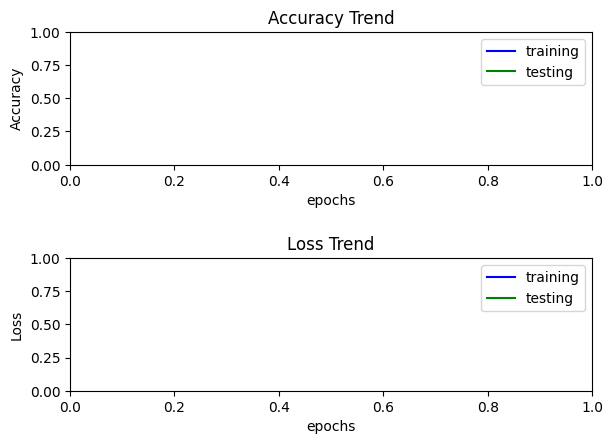

1/1 [==============================] - 14s 14s/step
y_pred [[0.54459953 0.4554004 ]
 [0.54579073 0.4542092 ]
 [0.5413151  0.45868495]
 [0.54331714 0.4566829 ]
 [0.54363656 0.4563634 ]
 [0.54387057 0.4561295 ]
 [0.54421914 0.45578074]
 [0.5448871  0.4551129 ]
 [0.54597795 0.45402193]
 [0.54394794 0.45605212]
 [0.5435254  0.45647463]
 [0.5431168  0.4568832 ]
 [0.54362637 0.45637366]
 [0.5440028  0.4559972 ]
 [0.5429298  0.4570702 ]
 [0.54279006 0.4572099 ]
 [0.5451249  0.4548751 ]
 [0.54221946 0.45778057]
 [0.54567766 0.45432234]
 [0.54490894 0.45509103]
 [0.54467    0.45533   ]
 [0.54235154 0.45764843]]
y_val tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(22, 2), dtype=float32)
y_pred [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_val [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Type of y_pred using model.predict: <c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Output shape of the model: (None, 2)
88/88 [==============================] - 255s 3s/step - loss: 0.8667 - accuracy: 0.6023 - val_loss: 0.8110 - val_accuracy: 0.3182


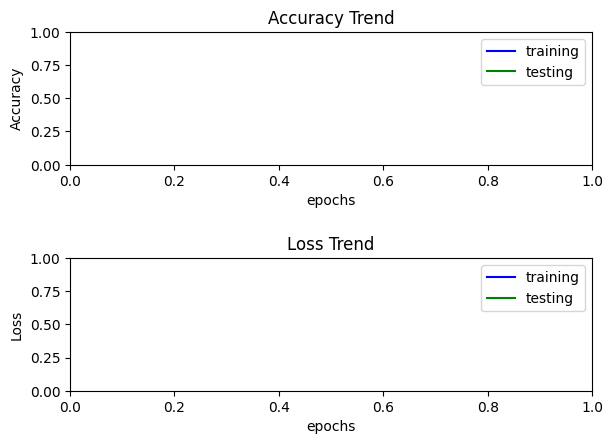

1/1 [==============================] - 14s 14s/step
y_pred [[0.61823136 0.3817686 ]
 [0.61821955 0.38178036]
 [0.6166468  0.3833532 ]
 [0.6177887  0.3822113 ]
 [0.6202471  0.37975287]
 [0.61801946 0.38198057]
 [0.618339   0.38166103]
 [0.6189767  0.38102332]
 [0.619726   0.38027397]
 [0.6192165  0.38078344]
 [0.6193951  0.38060483]
 [0.6195376  0.38046226]
 [0.6191392  0.38086072]
 [0.62055206 0.379448  ]
 [0.6173772  0.3826228 ]
 [0.617386   0.38261414]
 [0.61870044 0.3812995 ]
 [0.61821866 0.3817813 ]
 [0.6145548  0.3854452 ]
 [0.61787105 0.38212895]
 [0.6178727  0.38212729]
 [0.6168857  0.38311428]]
y_val tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(22, 2), dtype=float32)
y_pred [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_val [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Type of y_pred using model.predict: <c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Output shape of the model: (None, 2)
88/88 [==============================] - 258s 3s/step - loss: 0.9057 - accuracy: 0.4773 - val_loss: 0.6941 - val_accuracy: 0.4091


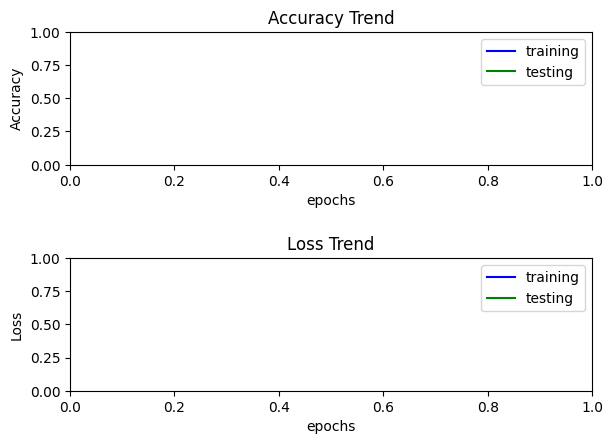

1/1 [==============================] - 14s 14s/step
y_pred [[0.5028578  0.4971421 ]
 [0.50283456 0.49716547]
 [0.5027751  0.49722487]
 [0.5028333  0.49716672]
 [0.5027311  0.49726886]
 [0.50285244 0.49714744]
 [0.5028295  0.49717048]
 [0.5030012  0.4969987 ]
 [0.5027422  0.49725783]
 [0.50301075 0.49698922]
 [0.50277966 0.4972203 ]
 [0.50272775 0.4972723 ]
 [0.50288177 0.49711823]
 [0.5029507  0.49704924]
 [0.50252116 0.49747878]
 [0.5030265  0.49697348]
 [0.5028762  0.49712378]
 [0.5031073  0.49689272]
 [0.5029167  0.49708337]
 [0.50303465 0.49696532]
 [0.5029888  0.49701113]
 [0.50319874 0.49680123]]
y_val tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(22, 2), dtype=float32)
y_pred [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_val [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Type of y_pred using model.predict: <c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Output shape of the model: (None, 2)
88/88 [==============================] - 260s 3s/step - loss: 0.8501 - accuracy: 0.5000 - val_loss: 0.9790 - val_accuracy: 0.3182


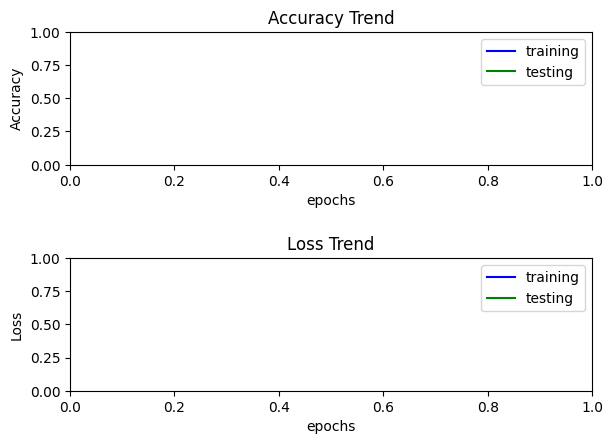

1/1 [==============================] - 14s 14s/step
y_pred [[0.26945284 0.73054713]
 [0.26671326 0.7332867 ]
 [0.27017763 0.72982246]
 [0.26906234 0.73093754]
 [0.26681104 0.733189  ]
 [0.26979354 0.73020643]
 [0.26871115 0.7312889 ]
 [0.28045297 0.71954703]
 [0.27286065 0.7271394 ]
 [0.27733508 0.72266495]
 [0.27430412 0.7256958 ]
 [0.27500463 0.7249953 ]
 [0.27731255 0.7226875 ]
 [0.27884045 0.7211596 ]
 [0.27346164 0.72653836]
 [0.2750429  0.72495705]
 [0.26892996 0.7310701 ]
 [0.27409852 0.72590154]
 [0.27314878 0.7268512 ]
 [0.27724892 0.7227511 ]
 [0.2766663  0.7233337 ]
 [0.27535865 0.7246414 ]]
y_val tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(22, 2), dtype=float32)
y_pred [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
y_val [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type of y_pred using model.predict: <c

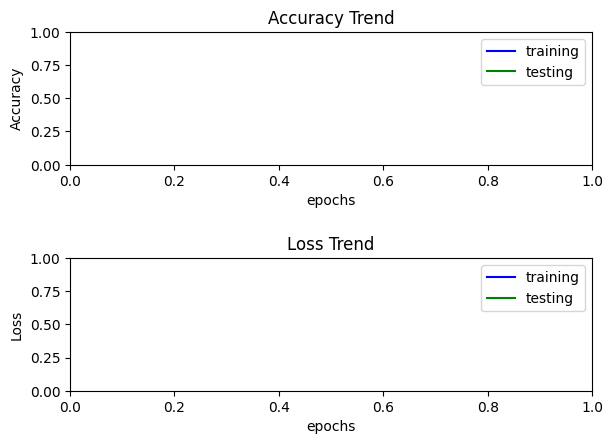

1/1 [==============================] - 14s 14s/step - loss: 0.6876 - accuracy: 0.8182


1/1 [==============================] - 16s 16s/step
y_pred [[0.5003344  0.49966568]
 [0.49186993 0.5081301 ]
 [0.4964644  0.50353557]
 [0.49804732 0.5019526 ]
 [0.49502996 0.50496995]
 [0.4955412  0.5044587 ]
 [0.49756998 0.50243   ]
 [0.49322382 0.5067762 ]
 [0.49438658 0.50561345]
 [0.49183694 0.5081631 ]
 [0.50061154 0.4993884 ]
 [0.5029089  0.4970911 ]
 [0.50055    0.49945006]
 [0.49900466 0.50099534]
 [0.4994509  0.5005491 ]
 [0.4999276  0.5000724 ]
 [0.50221354 0.49778646]
 [0.5009683  0.49903163]
 [0.5003698  0.4996303 ]
 [0.50463074 0.4953692 ]
 [0.50395274 0.4960472 ]
 [0.5006436  0.4993564 ]]
y_val tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(22, 2), dtype=float32)
y_pred [0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0]
y_val [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Type of y_pred using model.predict: <c

In [ ]:
# Define a list of choices
# choices = ['A', 'B', 'C', 'D']
choices = ['A']

# Create an empty dictionary to store the result dataframes
result_dfs = {}

# Loop through each choice
for choice in choices:
    # Call the driver() function with the current choice
    result_df = driver(choice)

    # Store the result dataframe in the dictionary with the choice as the key
    result_dfs[choice] = result_df

In [ ]:
print(result_dfs['A'])

In [ ]:
print(result_dfs['B'])

In [ ]:
print(result_dfs['C'])

In [ ]:
print(result_dfs['D'])